# 1. Data

In [79]:
import pandas as pd
import numpy as np
import ijson
from tqdm.notebook import tqdm
import networkx as nx
import community  # Louvain method
import matplotlib.pyplot as plt
import ast
import itertools

In order to open the json dataset, called "dblp.v12.json", we downloaded from kaggle do to memory issues, we converted the file to a csv file and then to a dataframe, keeping only the most important information for the purposes of the homework.\
The code in the following cell has been adapted from the one we found in the 'code' section of our kaggle's dataset; it has been added the extraction of the information related to the autor's info.

font link: https://www.kaggle.com/code/devintheai/citation-network-eda .




In [2]:
"""
PAPERS = []

with open("./dblp.v12.json", "rb") as f:
    for i, element in tqdm(enumerate(ijson.items(f, "item"))):
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']

        authors = element.get('authors')
        if authors:
            paper['num_authors'] = len(authors)
            # joining all authors in a list
            paper['authors'] = [auth for auth in authors]
        
        year = element.get('year')
        if year:
            paper['year']= year
        else:
            paper['year']= np.nan
        
        n_citation= element.get('n_citation')
        if n_citation:
             paper['n_citation']= element['n_citation']
        else:
            paper['n_citation']= 0
        
        doc_type= element.get('doc_type') 
        if doc_type:
            paper['doc_type']= element['doc_type']
        else:
            paper['doc_type']= np.nan      

        references= element.get('references')
        if references:
            paper['reference_count']= len(references)
            # joining all refs id in a `;` seperated string  
            paper['references']= ';'.join([str(int(r)) for r in references])
        else:
            paper['reference_count']= np.nan 
            paper['references']= np.nan
        
        doi = element.get('doi')
        if doi:
            paper['doi']= f"https://doi.org/{element['doi']}"
        else:
            paper['doi']= np.nan               
        
        
        PAPERS.append(paper)
"""

'\nPAPERS = []\n\nwith open("./dblp.v12.json", "rb") as f:\n    for i, element in tqdm(enumerate(ijson.items(f, "item"))):\n        paper = {}\n        paper[\'id\'] = element[\'id\']\n        paper[\'title\'] = element[\'title\']\n\n        authors = element.get(\'authors\')\n        if authors:\n            paper[\'num_authors\'] = len(authors)\n            # joining all authors in a list\n            paper[\'authors\'] = [auth for auth in authors]\n        \n        year = element.get(\'year\')\n        if year:\n            paper[\'year\']= year\n        else:\n            paper[\'year\']= np.nan\n        \n        n_citation= element.get(\'n_citation\')\n        if n_citation:\n             paper[\'n_citation\']= element[\'n_citation\']\n        else:\n            paper[\'n_citation\']= 0\n        \n        doc_type= element.get(\'doc_type\') \n        if doc_type:\n            paper[\'doc_type\']= element[\'doc_type\']\n        else:\n            paper[\'doc_type\']= np.nan      

Now we'll convert the information extracted in a dataframe and save them in a csv file, called "citations_network.csv"

In [ ]:
"""
data = pd.DataFrame(PAPERS)
data.head()
data.to_csv("citations_network.csv", index=False)
"""

That's the new dataset to create our subgraph for our investigation. Considering only the most connected componet of the graph.

In [2]:
file_path = r"D:\Primo Semestre\ADM\HW5\citations_network.csv"
df = pd.read_csv(file_path)

In [5]:
df.head()

,id,title,num_authors,authors,year,n_citation,doc_type,reference_count,references,doi
0,1091,Preliminary Design of a Network Protocol Learn...,8.0,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",2013.0,1,Conference,2.0,2005687710;2018037215,https://doi.org/10.1007/978-3-642-39476-8_19
1,1388,Further Results on Independence in Direct-Prod...,1.0,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",2000.0,1,Journal,NaN,NaN,NaN
2,1674,A methodology for the physically accurate visu...,2.0,"[{'name': 'G. Beale', 'org': 'Archaeological C...",2011.0,1,Conference,15.0,1535888970;1992876689;1993710814;2035653341;20...,https://doi.org/10.2312/VAST/VAST11/137-144
3,1688,"Comparison of GARCH, Neural Network and Suppor...",4.0,"[{'name': 'Altaf Hossain', 'org': 'Department ...",2009.0,6,Conference,3.0,1560724230;1986968751;2156909104,https://doi.org/10.1007/978-3-642-11164-8_97
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,4.0,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",2009.0,0,Conference,NaN,NaN,NaN


In [3]:
df.shape

(4894081, 10)

## Data pre-processing
1. identify the top **10,000** papers with the highest number of citations
   
We just sorted the entire dataset in descending order according to the number of citation of each paper, and kept the first 10,000 rows.


In [4]:
# Convert 'n_citation' column to numeric type if it contains mixed data types
df['n_citation'] = pd.to_numeric(df['n_citation'], errors='coerce')

# Sort the DataFrame by 'n_citation' column in descending order
df_sorted = df.sort_values(by='n_citation', ascending=False)

# Take the top 10,000 rows after sorting and reset the index
df_s = df_sorted.head(10000).reset_index(drop=True)

In [5]:
# converting the authors' information from string to list
df_s['authors'] = df_s['authors'].apply(lambda row: ast.literal_eval(row))

In [6]:
df_s.head()

,id,title,num_authors,authors,year,n_citation,doc_type,reference_count,references,doi
0,2041404167,The Mathematical Theory of Communication,1.0,"[{'name': 'C. E. Shannon', 'org': 'External Or...",1949.0,48327,Book,NaN,NaN,NaN
1,1639032689,"Genetic algorithms in search, optimization, an...",1.0,"[{'name': 'David E. Goldberg', 'id': 2102678951}]",1989.0,44175,Book,NaN,NaN,NaN
2,2912565176,Fuzzy sets,1.0,"[{'name': 'Lotfi A. Zadeh', 'id': 2252586558}]",1996.0,42437,NaN,NaN,NaN,NaN
3,2151103935,Distinctive Image Features from Scale-Invarian...,1.0,"[{'name': 'David G. Lowe', 'org': 'Computer Sc...",2004.0,35541,Journal,33.0,19720318;1541642243;1560959218;1676552347;1681...,https://doi.org/10.1023/B:VISI.0000029664.9961...
4,2911964244,Random Forests,1.0,"[{'name': 'Leo Breiman', 'org': 'Statistics De...",2001.0,34741,NaN,11.0,1507255258;1580948147;1605688901;1975846642;20...,https://doi.org/10.1023/A:1010933404324


### Citation graph
- Representation of the paper's *citation relationships*, where each node is a paper and the edge between two nodes is present only if the starting node cites the second node.
- Unweighted
- Directed

2. The **nodes** of the graph

In [7]:
# the nodes of the graph will be all the unique rows that are present in the dataset

# creating the directed graph
cit_G = nx.DiGraph(name = 'Citation Graph')

# adding the nodes and the attributes (the columns of the dataset)
for i, pap in df_s.iterrows():
    node = pap['id']
    attributes = {}
    for el in list(df_s.columns)[1:]:
        attributes[el] = pap[el]
    cit_G.add_node(node, **attributes)

print(f'number of nodes in the Citation Graph: {len(cit_G.nodes())}')

number of nodes in the Citation Graph: 10000


3. The **edges** of the graph

The edges are defined by simply connecting each edge with all the paper's ids that specific paper cites; those can be found in the feature *references*.\
Those ids have been stored in a string separated by the ";", so what we'll do is to create a dictionary that is structured in the following way:
```python
result_dict = {node_A : [node_B, node_c...], node_B : [node_i, ... ]}
```
where the key is the starting node and its value is a list of all the reachable nodes from it.

In [8]:
# the edges are all the papers' ids in the 'references' column
def citation_dict(row, d={}):
    if pd.notnull(row['references']):
        d[row['id']] = [int(cit) for cit in row['references'].split(';')]
    return d

# apply the function to each row in the DataFrame to save the citation's relationship in a dictionary
result_dict = {}
for idx, row in df_s.iterrows():
    result_dict = citation_dict(row, result_dict)

Now we'll use the dictionary ```result_dict``` to create the directed edges in the graph

In [9]:
for start in result_dict.keys():
    for end in result_dict[start]:
        cit_G.add_edge(start, end)

In [10]:
print(f'number of nodes in the Citation Graph considering all the citations: {len(cit_G.nodes())}')

number of nodes in the Citation Graph considering all the citations: 100858


If we're interested in a rapresentatin of a portion of the graph (a subgraph of about 20 nodes, for the sake of a clearer view)

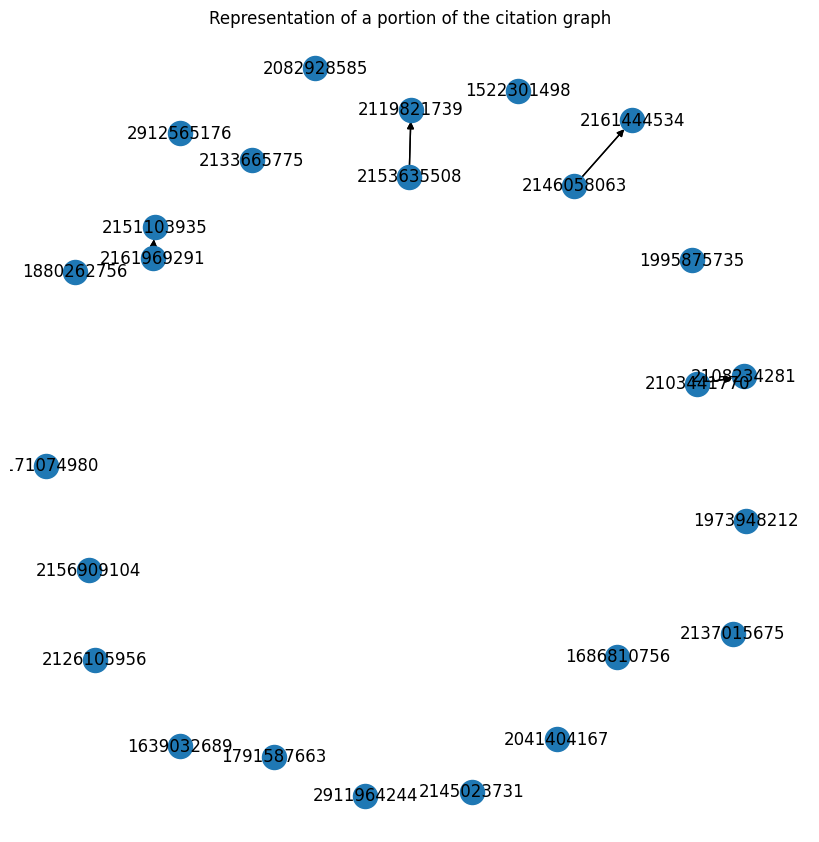

In [11]:
# creating a subgraph of nodes
subgraph = cit_G.subgraph(list(cit_G.nodes())[:25])
position = nx.spring_layout(subgraph)
plt.figure(figsize=(8,8))
nx.draw(subgraph, with_labels=True, pos= position)
nx.draw_networkx_edges(subgraph, pos=position)
plt.title('Representation of a portion of the citation graph')
plt.show()

### Collaboration graph
- Represents the *collaborations of the paper's authors*, where each node is an author and the undirected edge between two nodes represents the fact that those two authors have collaborated in a research paper. 
- Weighted: the weight will be the the number of research papers the couple of authors have worked on together.
- Undirected

2. The **nodes** of the graph
3. The **edges** of the graph: undirected and weighted

In [12]:
collab_G = nx.Graph(name = 'Collaboration Graph') 

In [13]:
tqdm.pandas()

# dictionary to count the collaborations between each author's couple 
author_collaborations = {}
for authors_list in df_s['authors']:
    author_ids = [author['id'] for author in authors_list]  # extract the author's id for each paper
    author_combinations = itertools.combinations(author_ids, 2) # find all the possible combinations of the authors for the current paper
    
    for pair in author_combinations: # keep the count of the collaborations for each author's couple
        pair = tuple(sorted(pair))  # sort the ids to keep coherence in the couple
        if pair not in author_collaborations.keys():
            author_collaborations[pair] = 1
        else:
            author_collaborations[pair] += 1

# now create the graph with the author's couple of edges, networkX will automatically create the nodes if not present already

for authors, num_collab in author_collaborations.items():
    author1, author2 = authors
    collab_G.add_edge(author1, author2, weight=num_collab) # create the graph with the weighted edges: the number of times each author worked with the other

# now we have to add all the authors that have never collaborated with anyone else  
def apply_record(G, data):
  authors_list = []
  for author in data['authors']:
    authors_list.append(author['id'])
    G.add_node(author['id'], name=author['name'])
    if 'org' in author:
      G.nodes()[author['id']]['org'] = author['org']

df_s.progress_apply(lambda row: apply_record(collab_G, row), axis=1)

print(f'number of nodes in the Collaboration Graph: {len(collab_G.nodes())}')
print(f'number of edges in the Collaboration Graph: {len(collab_G.edges())}')

  0%|          | 0/10000 [00:00<?, ?it/s]

number of nodes in the Collaboration Graph: 21235
number of edges in the Collaboration Graph: 136478


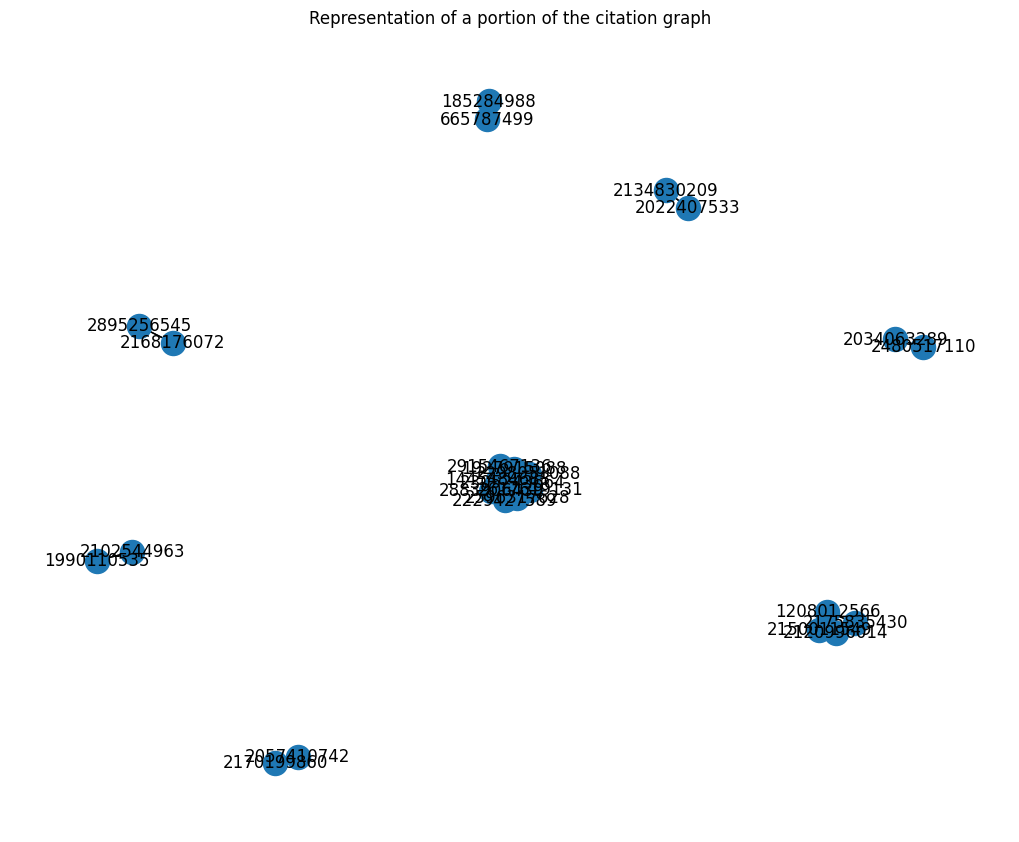

In [15]:
# creating a subgraph of nodes
subgraph = collab_G.subgraph(list(collab_G.nodes())[:25])
position = nx.spring_layout(subgraph)
plt.figure(figsize=(10,8))
nx.draw(subgraph, with_labels=True, pos= position)
nx.draw_networkx_edges(subgraph, pos=position)
plt.title('Representation of a portion of the citation graph')
plt.show()

As a final step, we can save the graphs in a GraphML file

In [16]:
nx.write_graphml(collab_G, "Collaboration_Graph.graphml")

# in order to save the citation graph, we have to remove the author attribute, because is a list and is not supported by GraphML
for node in cit_G.nodes():
    if 'authors' in cit_G.nodes[node]:
        del cit_G.nodes[node]['authors']
nx.write_graphml(cit_G, "Citation_Graph.graphml")

# 2. Controlling system

## 2.1. Backend Implementation

### Functionality 1 - Graph's features

Let's first read graphs from Citation and Collaboration graphs:

In [80]:
def read_graphs():
    citation_graph = nx.read_graphml('./Citation_Graph.graphml')
    collaboration_graph = nx.read_graphml('./Collaboration_Graph.graphml')
    return citation_graph, collaboration_graph

# Read graphs
citation_graph, collaboration_graph = read_graphs()

In [81]:
# This method, creates a subgraph from a given graph with N number of first nodes to consider
def create_subgraph(graph, N, add_edges = False):   
    subset_nodes = list(graph.nodes())[:N]  # Selects the first 'N' nodes in the graph
    subgraph = nx.Graph()  # Creates an empty graph object
    subgraph.add_nodes_from(subset_nodes)  # Adds the subset_nodes to the subgraph
    if add_edges:
        subgraph.add_edges_from(graph.subgraph(subset_nodes).edges())
    return subgraph

- In the following method, we calculate the number of nodes and edges, deensity, Degree-related values for a given graph including degree distribution, average degree amount, hubs, and a boolean is_dense variable.
 
- For calculatinng the density of the graph we used NetworkX's. A density of 0 means that the number of edges in the graph is close to the minimum number of edges needed for a graph of that size. Consequently, it implies the graph is relatively sparse, with fewer connections between nodes compared to the maximum possible connections.

- For networks like citation networks, sparsity might be natural and not every node paper is connected to every other node.

- **Note:**
    - If the density of the graph is close to 1, it's considered dense.
    - If the density is closer to 0, it's considered sparse.

In [82]:
def graph_features(graph, graph_name):

    # number of nodes and edges:
    number_of_nodes = graph.number_of_nodes()
    number_of_edges = graph.number_of_edges()
    
    # Calculate the density of the graph using NetworkX's 
    density = nx.density(graph)
    
    # Degree histogram returns a list of counts where the index is the degree
    degree_distribution = nx.degree_histogram(graph)

    # Calculate the average degree of the graph
    avg_degree = sum(dict(graph.degree()).values()) / len(graph)

    # Calculate degrees of all nodes
    degrees = dict(graph.degree())
    
    # Calculate the 95th percentile of the degree distribution
    percentile_95 = np.percentile(list(degrees.values()), 95)
    
    # Identify nodes that are hubs (nodes with degrees higher than the 95th percentile)
    hubs = [node for node, degree in degrees.items() if degree > percentile_95]
    

    
    # Set a threshold for determining if the graph is dense or sparse
    # we assigned 0.0005 to the threshold, to divide citation and collabration graphs 
    # into 2 groups of sparse and dense.
    threshold = 0.0005  # threshold value for density comparison.
    is_dense = False
    
    if density >= threshold:
        is_dense = True
    else:
        is_dense = False

    return number_of_nodes, number_of_edges, degree_distribution, avg_degree, is_dense, hubs

In [83]:
# # Test method-1
# graph_features(citation_graph, "citation")
# graph_features(collaboration_graph, "collaboration")

## Functionality 2 - Nodes' contribution

This function takes a graph and a specific node within that graph as input.
It computes various centrality measures for the specified node in the given graph.

**betweenness centrality:**

We compute the betweenness centrality for all nodes in the graph using NetworkX's betweenness_centrality function. Betweenness Centrality is a metric used in network analysis to identify the importance of a node within a graph based on its centrality in the flow of information between other nodes.

- Betweenness Centrality calculates the shortest paths between all pairs of nodes in a graph.
- For each node 'v' in the graph, it counts the number of these shortest paths that pass through 'v'.
- Nodes with higher betweenness centrality scores are considered more important in the transfer of information within the network.
- The usecase for betweenness centrality is to Identify critical nodes and to Understand nodes that act as bridges.

**PageRank:**

It measures the importance of a node based on the idea of "importance by association." 

- PageRank considers a node important if it is pointed to by other important nodes.
- It assumes a web-like structure where nodes are web pages, and edges are hyperlinks between pages.
- PageRank includes a damping factor (usually set to around 0.85) to model the probability that a user randomly jumps from one page to another instead of following links.

If we want to apply PageRank on our system, 

- Initially, all nodes are assigned an equal probability or "importance score."
- The algorithm iterates through the nodes' connections, adjusting their scores based on incoming links from other nodes.
- A node's importance is distributed among the nodes it points to, divided by the number of outbound links.
- The process continues by updating node importance based on the importance of the nodes pointing to them. till the time that the importance scores no longer change significantly between iterations.

**Closeness Centrality:**

It assesses how quickly a node can interact with other nodes in the network, considering the shortest paths between the node and all other nodes.

- Proximity to Others: It evaluates how quickly a node can reach all other nodes in the network.
- Shortest Paths: Closeness Centrality is based on the sum of the shortest path lengths from a node to all other nodes in the network.
- How to calculate Closeness?
    1) the shortest paths to all other nodes should be computed.
    2) Sum up these path lengths from the node to all other nodes.
    3) The reciprocal of this sum is taken to normalize the value, making nodes with lower total path lengths (closer to all other nodes) have higher closeness centrality scores.
 
**Degree Centrality**

It determines the importance or centrality of a node within a network. It's based on the number of links (edges) connected to a node.

- Nodes with higher degree centrality are often considered more influential or important within the network due to their numerous connections.
- High degree nodes are often hubs in the network, serving as central points of connection or information exchange.

In [84]:
def nodes_contribution(graph, node, graph_name):    
    # Calculate Betweenness Centrality for all nodes
    betweenness = nx.betweenness_centrality(graph)
    
    # Get Betweenness Centrality for the specified node
    node_betweenness = betweenness.get(node)
    
    # Calculate PageRank centrality for all nodes
    pagerank = nx.pagerank(graph)
    
    # Get PageRank centrality for the specified node
    node_pagerank = pagerank.get(node)
    
    # Calculate Closeness Centrality for all nodes
    closeness = nx.closeness_centrality(graph)
    
    # Get Closeness Centrality for the specified node
    node_closeness = closeness.get(node)

    # Calculate Degree Centrality for all nodes
    degree_centrality = nx.degree_centrality(graph)
    
    # Get Degree Centrality for the specified node
    node_degree_centrality = degree_centrality.get(node)
    
    return node_betweenness, node_pagerank, node_closeness, node_degree_centrality

## Functionality 3 - Shortest ordered walk

below, we tried to find the shortest ordered walk between specified nodes in a graph.

- first, we checked the a_1 and a_n, and then created our own ordered nodes.
- Then, we iterate through the list of ordered nodes and find the shortest path between each pair of consecutive nodes using nx.shortest_path.
- We Appended all intermediate nodes from each shortest path (excluding the last node) to the shortest_path list. and finally we added the last a_n node to the shortest path.

In [96]:
def bfs_shortest_path(graph, start, end):
    # Initialize a queue with the start node
    queue = [[start]]
    # Check if start and end nodes are the same
    if start == end:
        return [start]
    # Loop until the queue is empty
    while queue:
        # Take the first path from the queue
        path = queue.pop(0)
        # Get the last node from the path
        node = path[-1]
        # Explore neighbors of the current node
        for adjacent in graph.neighbors(node):
            # Create a new path by appending the neighbor to the current path
            new_path = list(path)
            new_path.append(adjacent)
            # Add the new path to the queue for further exploration
            queue.append(new_path)
            # Check if the neighbor is the end node
            if adjacent == end:
                return new_path  # Return the path if it reaches the end node
    return "There is no such path."  # Return if there's no path to the end node

def shortest_ordered_walk(graph, authors_a, a_1, a_n):
    # Check if a_1 and a_n are in the graph
    if a_1 not in graph or a_n not in graph:
        return "One or more authors are not present in the graph."

    # Create a list to store the ordered nodes
    ordered_nodes = [a_1] + authors_a + [a_n]

    shortest_path = []  # Initialize an empty list to store the nodes in the shortest path

    # Loop through the ordered_nodes list to find shortest paths between consecutive nodes
    for i in range(len(ordered_nodes) - 1):
        # Find the shortest path between current node (ordered_nodes[i]) and the next node (ordered_nodes[i + 1])
        path = bfs_shortest_path(graph, ordered_nodes[i], ordered_nodes[i + 1])
        # Check if there is no such path
        if path == "There is no such path.":
            return "There is no such path."
        # Add the nodes from the path (excluding the first node) to the shortest_path list
        shortest_path.extend(path[1:])  # Exclude the first node to avoid duplication
    return shortest_path


## Functionality 4 - Disconnecting Graphs

Here, we find the minimum number of edges that need to be removed from a graph to disconnect two specific authors, author_a and author_b, given a set of top_authors.

- first, we filter the top_authors list to include only those authors that exist as nodes in the given graph.
- We created a copy for the graph in order not to alter the actual graph data.
- we specifuied edges between pairs of top authors (top_authors_data) and create a list edges_to_remove containing those edges.
- Then, we removed those identified edges from the copied graph temp_graph.


In [152]:
# Define a function to check if a path exists between two nodes in a graph
def has_path(graph, start, end):
    visited = set()  # Create an empty set to track visited nodes
    queue = []  # Create an empty list to act as a queue for BFS

    queue.append(start)  # Add the starting node to the queue
    visited.add(start)  # Mark the starting node as visited in the set

    while queue:  # Continue looping while the queue is not empty
        node = queue.pop(0)  # Dequeue the first node from the queue for processing
        if node == end:  # Check if the current node is the destination node
            return True  # If the destination node is reached, return True
        for neighbor in graph[node]:  # Iterate through neighbors of the current node
            if neighbor not in visited:  # Check if the neighbor is not visited
                queue.append(neighbor)  # Add the neighbor to the queue for further exploration
                visited.add(neighbor)  # Mark the neighbor as visited in the set
    return False  # If the destination node is not reached, return False

# Function to find the minimum edges to disconnect two nodes
def min_edges_to_disconnect(graph, node_a, node_b, top_authors):
    # Create an empty dictionary to store graph connections
    connections = {}

    # Construct the graph connections
    for edge in graph.edges():  # Iterate through edges in the graph
        if edge[0] in top_authors and edge[1] in top_authors:  # Check if both nodes are in the top authors
            if edge[0] not in connections:  # If node not in connections, add it to the dictionary
                connections[edge[0]] = []
            if edge[1] not in connections:  # If node not in connections, add it to the dictionary
                connections[edge[1]] = []
            connections[edge[0]].append(edge[1])  # Add edge connections for node 0
            connections[edge[1]].append(edge[0])  # Add edge connections for node 1

    # Remove the edge between node_a and node_b
    connections[node_a].remove(node_b)  # Remove the edge from node_a to node_b
    connections[node_b].remove(node_a)  # Remove the edge from node_b to node_a

    # Check if there's still a path between node_a and node_b after edge removal
    if has_path(connections, node_a, node_b):
        return 0  # No edges need to be removed, as there's still a path

    # If there's no path, start removing edges incrementally until a path is disrupted
    removed_edges = 0  # Initialize the count of removed edges
    while not has_path(connections, node_a, node_b):  # While no path exists between nodes
        removed_edges += 1  # Increment the count of removed edges
        if not connections[node_a] or not connections[node_b]:  # If no edges left for nodes
            break  # Exit the loop
        edge_to_remove = connections[node_a].pop(0)  # Remove an edge from node_a
        connections[edge_to_remove].remove(node_a)  # Remove the corresponding edge from the other node

    return removed_edges  # Return the count of removed edges required to disconnect nodes    while has_path(connections, node_a, node_b):
        possible_edges = [(a, b) for a in connections[node_a] for b in connections[node_b]]
        if not possible_edges:
            break
        edge_to_remove = possible_edges[0]  # Remove the first edge found
        connections[edge_to_remove[0]].remove(edge_to_remove[1])
        connections[edge_to_remove[1]].remove(edge_to_remove[0])
        removed_edges += 1

    return removed_edges

## Functionality 5 - Extracting Communities

Here we create a subgraph based on a subset of nodes, detect communities within this subgraph, calculate the minimum edges needed to be removed for the communities, and check if two specified papers belong to the same community within these detected communities.

In [87]:
# Function to get neighbors of a node in a graph
def get_neighbors(graph, node):
    return list(graph[node])

# Function to calculate modularity given a graph and a set of communities
def calculate_modularity(graph, communities):
    m = sum(graph.degree().values()) / 2  # Calculate the total number of edges in the graph
    modularity = 0

    # Iterate through communities
    for community in communities:
        for i in community:
            for j in community:
                # Calculate A_ij (presence/absence of edge) between nodes i and j
                A_ij = 1 if i in get_neighbors(graph, j) else 0
                ki = len(get_neighbors(graph, i))  # Degree of node i
                kj = len(get_neighbors(graph, j))  # Degree of node j

                # Update modularity based on the modularity formula
                modularity += (A_ij - (ki * kj) / (2 * m))

    modularity /= 2 * m  # Normalize modularity
    return modularity

# Function to find communities using a greedy modularity optimization algorithm
def greedy_modularity_communities(graph):
    communities = []
    node_to_community = {node: i for i, node in enumerate(graph.nodes())}  # Assign each node to its own community

    # Initialize communities
    for node in graph.nodes():
        communities.append({node})

    modularity_gain = True  # Initialize modularity gain flag
    while modularity_gain:
        modularity_gain = False
        for node in graph.nodes():
            current_community = node_to_community[node]
            best_community = current_community
            max_modularity = 0

            # Iterate through neighbors of the node
            for neighbor in get_neighbors(graph, node):
                neighbor_community = node_to_community[neighbor]
                communities[current_community].remove(node)
                communities[neighbor_community].add(node)

                # Calculate modularity after moving the node to the neighbor's community
                modularity = calculate_modularity(graph, communities)
                if modularity > max_modularity:
                    max_modularity = modularity
                    best_community = neighbor_community

                communities[current_community].add(node)
                communities[neighbor_community].remove(node)

            # Move the node to the best community if it improves modularity
            if best_community != current_community:
                communities[current_community].remove(node)
                communities[best_community].add(node)
                node_to_community[node] = best_community
                modularity_gain = True  # Set modularity gain flag to True

    return [set(community) for community in communities]  # Return communities as sets

# Function to extract communities, modularity, and check if two papers belong to the same community
def extract_communities(graph, paper_1, paper_2):
    # Create a subgraph from 100 nodes with added edges to illustrate in plot
    subgraph = create_subgraph(graph, 100, True)

    # Detect communities using the custom greedy algorithm
    communities = greedy_modularity_communities(subgraph)

    # Find the minimum number of edges to remove for communities to be separated (modularity)
    num_edges_to_remove = calculate_modularity(subgraph, communities)

    # Check if Paper_1 and Paper_2 belong to the same community
    same_community = any([paper_1 in community and paper_2 in community for community in communities])

    return num_edges_to_remove, communities, same_community, subgraph  # Return relevant information

## 2.2. Frontend Implementation

### Visualization 1 - Visualize graph features

Here we created a table, representing the desired features of both Citation and Collabration graph.
In the table, we show:

- Number of nodes in the graph
- Number of the edges in the graph
- Density of the graph
- Average degree of the graph
- Whether the network is sparse or dense
- lists the graph's hubs

In [28]:
# Collect information for citation_graph and collaboration_graph
citation_info = graph_features(citation_graph, "citation")
collaboration_info = graph_features(collaboration_graph, "collaboration")

# Create a DataFrame to hold the information
data = {
    'Number of Nodes': [citation_info[0], collaboration_info[0]],
    'Number of Edges': [citation_info[1], collaboration_info[1]],
    'Density': [citation_info[2], collaboration_info[2]],
    'Average Degree': [citation_info[3], collaboration_info[3]],
    'Network Type': ['Dense' if citation_info[4] else 'Sparse', 'Dense' if collaboration_info[4] else 'Sparse'],
    'Top 20 hubs': [citation_info[5][:20], collaboration_info[5][:20]]
}

feature_df = pd.DataFrame(data).T
feature_df = feature_df.rename(columns={0: "Citation", 1:"Collaboration"})
feature_df

# citation_info[5][:20], collaboration_info[5][:20]

,Citation,Collaboration
Number of Nodes,100830,21232
Number of Edges,187811,136463
Density,"[323, 67467, 14061, 5310, 2509, 1459, 846, 622...","[1030, 3231, 3493, 2714, 1860, 1313, 995, 695,..."
Average Degree,3.7253,12.854465
Network Type,Sparse,Dense
Top 20 hubs,"[2041404167, 1639032689, 2912565176, 215110393...","[1445484688, 2104401652, 2435751034, 200741513..."


Here is a plot depicting the distribution of the citations received by papers (Citation graph)

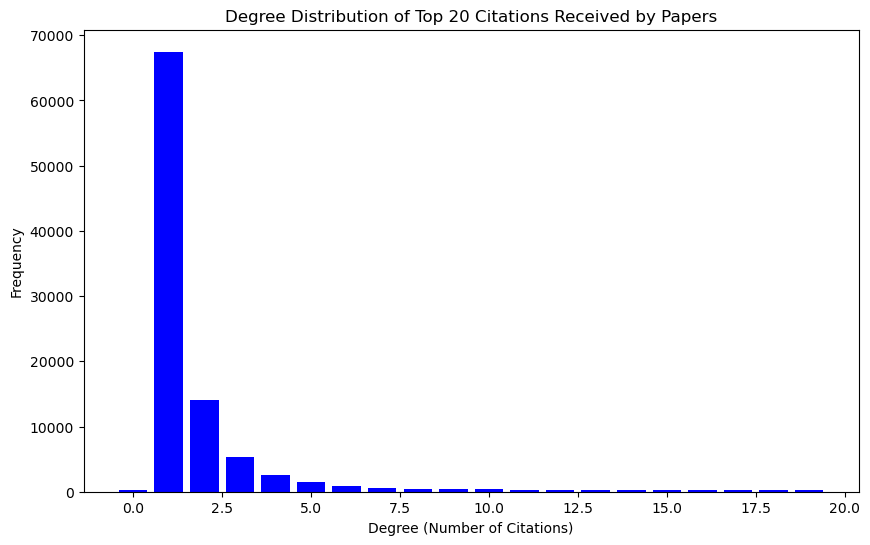

In [38]:
# Plotting top 20 degrees
degree_dist = citation_info[2]  # Accessing degree distribution from graph features

# Get degrees and frequencies for top 20 degrees
degrees = np.arange(0, 20)
top_degree_dist = degree_dist[:20]

plt.figure(figsize=(10, 6))
plt.bar(degrees, top_degree_dist, width=0.8, color='b')

plt.title('Degree Distribution of Top 20 Citations Received by Papers')
plt.xlabel('Degree (Number of Citations)')
plt.ylabel('Frequency')
plt.show()

Here is a plot depicting the distribution of the given citations by papers (Citation graph)

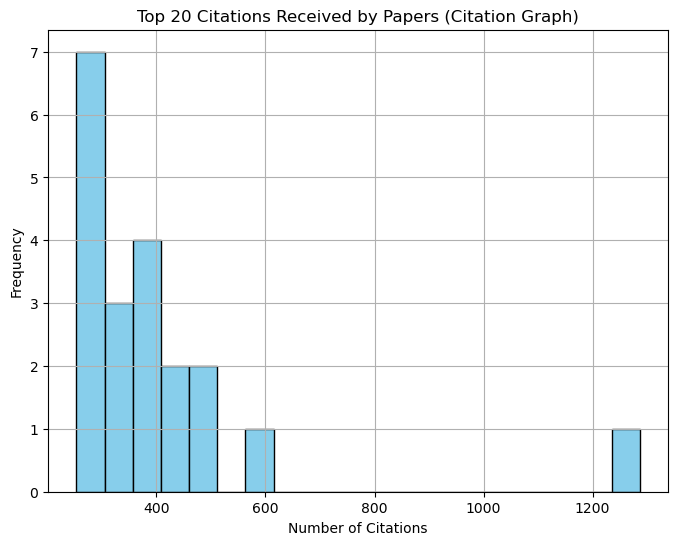

In [30]:
degrees = dict(citation_graph.degree())  # Extract degrees of nodes

# Get the top degrees and their frequencies
sorted_degrees = sorted(degrees.values(), reverse=True)
top_20_degrees = sorted_degrees[:20]

plt.figure(figsize=(8, 6))
plt.hist(top_20_degrees, bins=20, color='skyblue', edgecolor='black')
plt.title('Top 20 Citations Received by Papers (Citation Graph)')
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Here is a plot depicting the number of collaborations of the author (Collaboration graph)

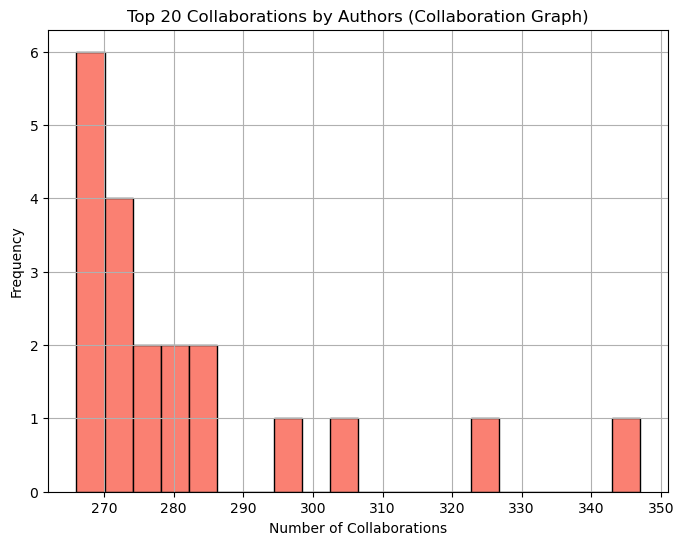

In [31]:
degrees = dict(collaboration_graph.degree())  # Extract degrees of nodes

# Get the top 20 degrees and their frequencies
sorted_degrees = sorted(degrees.values(), reverse=True)
top_20_degrees = sorted_degrees[:20]

plt.figure(figsize=(8, 6))
plt.hist(top_20_degrees, bins=20, color='salmon', edgecolor='black')
plt.title('Top 20 Collaborations by Authors (Collaboration Graph)')
plt.xlabel('Number of Collaborations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Visualization 2 - Visualize the node's contribution

Here, we created a sub graph from the main graphs, to process data easier on local machines.

In [40]:
# Considering top 10000 nodes of both graphs
citation_subgraph = create_subgraph(citation_graph, 10000)
collaboration_subgraph = create_subgraph(collaboration_graph, 10000)

- Here we selected nodes '2076063813' and '2146468246' for citation and collabration graphs respectively.
- you can change the nodes to calculate betweenness, page rank, closeness, and degree centrality of them based on your desire.

In [137]:
citation_contribution_info = nodes_contribution(citation_subgraph, "2076063813", "citation")
collaboration_contribution_info = nodes_contribution(collaboration_subgraph, "2146468246", "Collaboration")

In [138]:
# Create a DataFrame to hold the information
# Here we passed the 2nd node of both graphs to c
contribution_data = {
    'Node': [list(citation_graph.nodes())[1], list(collaboration_graph.nodes())[1]],
    'Node betweenness': [citation_contribution_info[0], collaboration_contribution_info[0]],
    'Node page rank': [citation_contribution_info[1], collaboration_contribution_info[1]],
    'Node closeness': [citation_contribution_info[2], collaboration_contribution_info[2]],
    'Node degree centrality': [citation_contribution_info[3], collaboration_contribution_info[3]]
}

contribution_df = pd.DataFrame(contribution_data).T
contribution_df = contribution_df.rename(columns={0: "Citation", 1: "Collaboration"})
contribution_df

,Citation,Collaboration
Node,1639032689,2102544963
Node betweenness,0.0,0.0
Node pagerank,0.0001,0.0001
Node closeness,0.0,0.0
Node degree centrality,0.0,0.0


### Visualization 3 - Visualize the shortest-ordered route

The code below, helps us to find the most important nodes with the highest number of connected nodes.

In [88]:
# Find all nodes with more than N connected nodes as their neighbors. So 'N' is number of connections
def find_connected_nodes(graph, N, graph_name):
    # Dictionary to store nodes with their neighbors
    nodes_with_neighbors = {}
    # Iterate through nodes and count their neighbors
    for node in list(graph.nodes())[:1000]:
        neighbors = list(graph.neighbors(node))
        if len(neighbors) > N:
            nodes_with_neighbors[node] = neighbors
    
    print(f"Nodes with more than {N} connected neighbors in {graph_name} graph:")
    # print(nodes_with_neighbors)                       # represent all findings
    print(dict(list(nodes_with_neighbors.items())[:5])) # represent only the first item of the array

In [89]:
find_connected_nodes(citation_graph, 8, "Citation")
find_connected_nodes(collaboration_graph, 8, "Collabration")

Nodes with more than 8 connected neighbors in Citation graph:
{'2151103935': ['19720318', '1541642243', '1560959218', '1676552347', '1681491849', '1949116567', '2011891945', '2012778485', '2024668293', '2027089475', '2034501924', '2056313036', '2071866949', '2085207288', '2096077837', '2096600681', '2096680898', '2109863423', '2110826265', '2111308925', '2124087378', '2124386111', '2124404372', '2143539328', '2145713909', '2149646227', '2149814923', '2154422044', '2160835070', '2162601563', '2165497495', '2169351022', '2427881153'], '2911964244': ['1507255258', '1580948147', '1605688901', '1975846642', '2077200366', '2099968818', '2112076978', '2113242816', '2120240539', '2152761983', '2912934387'], '2153635508': ['1510526001', '1543810117', '1556115774', '1568793342', '1621799579', '1775273161', '2011741120', '2036350498', '2047542122', '2056983531', '2087347434', '2096613134', '2097850441', '2100967622', '2104978738', '2110899801', '2115076892', '2115694019', '2119821739', '212435108

Code below, helps us to find connected nodes for a single desired node:

In [97]:
# Choose a single node to find its connected nodes

selected_citation_node = '2911964244'
selected_collabration_node = '2298051088'

# Get nodes connected to the selected node
connected_citation_nodes = list(citation_graph.neighbors(selected_citation_node))
connected_collabration_nodes = list(collaboration_graph.neighbors(selected_collabration_node))

print(f"Nodes connected to node {selected_citation_node} in Citation graph:")
print(connected_citation_nodes)
print(f"Nodes connected to node {selected_collabration_node} in Collaboration graph:")
print(connected_collabration_nodes)

Nodes connected to node 2911964244 in Citation graph:
['1507255258', '1580948147', '1605688901', '1975846642', '2077200366', '2099968818', '2112076978', '2113242816', '2120240539', '2152761983', '2912934387']
Nodes connected to node 2298051088 in Collaboration graph:
['1445484688', '2596317628', '2883906439', '2915467136', '2617619131', '2229427589', '1927915088', '2305243664']


In [98]:
# Usage for connected nodes in collaboration graph:
authors_sequence = ['2596317628', '2298051088', '2883906439', '2915467136', '2617619131', '2229427589', '1927915088', '2305243664', '1242522392', '2950088560', '2005895197', '2989625279', '164686048', '2923283658', '2279919673', '2113463369']
start_author = '1445484688'
end_author = '1958887586'

shortest_ordered_walk_result = shortest_ordered_walk(collaboration_graph, authors_sequence, start_author, end_author)
print("Shortest ordered walk:\n", shortest_ordered_walk_result)

Shortest ordered walk:
 ['2596317628', '2298051088', '2883906439', '2915467136', '2617619131', '2229427589', '1927915088', '2305243664', '1242522392', '2950088560', '2005895197', '2989625279', '164686048', '2923283658', '2279919673', '2113463369', '1958887586']


**Compare to Dijkstra:**

I asked chatGPT for a different one leveraging another approach in solving the shortest path. It suggested dijkstra algorithm. the results prove that the preevious method is correct.

In [101]:
import networkx as nx

def dijkstra_shortest_path(graph, start, end):
    try:
        shortest_path = nx.dijkstra_path(graph, start, end)
        return shortest_path
    except nx.NetworkXNoPath:
        return "There is no such path."

def shortest_ordered_walk_by_dijkstra(graph, authors_a, a_1, a_n):
    if a_1 not in graph or a_n not in graph:
        return "One or more authors are not present in the graph."

    ordered_nodes = [a_1] + authors_a + [a_n]

    shortest_path = []

    for i in range(len(ordered_nodes) - 1):
        path = dijkstra_shortest_path(graph, ordered_nodes[i], ordered_nodes[i + 1])
        if path == "There is no such path.":
            return "There is no such path."
        shortest_path.extend(path[:-1])  # Extend the path excluding the last node
    shortest_path.append(a_n)  # Append the final node a_n

    return shortest_path

# Usage for connected nodes in collaboration graph
authors_sequence = ['2596317628', '2298051088', '2883906439', '2915467136', '2617619131', '2229427589', '1927915088', '2305243664', '1242522392', '2950088560', '2005895197', '2989625279', '164686048', '2923283658', '2279919673', '2113463369']
start_author = '1445484688'
end_author = '1958887586'

shortest_ordered_walk_result_by_dijkstra = shortest_ordered_walk_by_dijkstra(collaboration_graph, authors_sequence, start_author, end_author)
print("Shortest ordered walk:\n", shortest_ordered_walk_result_by_dijkstra)


Shortest ordered walk:
 ['1445484688', '2596317628', '2298051088', '2883906439', '2915467136', '2617619131', '2229427589', '1927915088', '2305243664', '1242522392', '2950088560', '2005895197', '2989625279', '164686048', '2923283658', '2279919673', '2113463369', '1958887586']


- The following function illustratse the graph and highlights the edges and nodes in the shortest walk.
- this method, accepts the graph along with the shortest_walk, which is a list representing the nodes that we travel across in the shortest walk.

In [102]:
def plot_shortest_walk(subgraph, shortest_walk):

    pos = nx.spring_layout(subgraph)  # Define the layout for the graph
    plt.figure(figsize=(10, 8))
    
    # Draw the graph - We pass the sub-graph, so all nodes of subgraph will be displayed.
    nx.draw(subgraph, pos, with_labels=False, node_size=10, node_color='skyblue')

    # Highlight nodes and edges in the shortest walk - iterate through the nodes
    for i in range(len(shortest_walk) - 1):
        current_node = shortest_walk[i]
        next_node = shortest_walk[i + 1]

        # Highlight nodes in the shortest walk - draw the nodes that are connected and we want to set a path through them.
        nx.draw_networkx_nodes(
            subgraph, pos,
            nodelist=[current_node, next_node],
            node_color='red', node_size=100
        )

        # Draw the path (arrows)
        nx.draw_networkx_edges(
            subgraph, pos,
            edgelist=[(current_node, next_node)],
            edge_color='black', width=3, arrows=True
        )

        # Annotate edges with their order in the shortest walk - write numbers (steps) on each arrow of the path
        edge_label = i + 1
        edge_pos = pos[current_node] + (pos[next_node] - pos[current_node]) / 2
        plt.text(edge_pos[0], edge_pos[1], str(edge_label), fontsize=12, color='black')

    plt.title('Collaboration Graph with Shortest Ordered Walk')
    plt.axis('off')
    plt.show()

In [103]:
# Consider just first 2000 nodes:
collaboration_subgraph = create_subgraph(collaboration_graph, 2000)

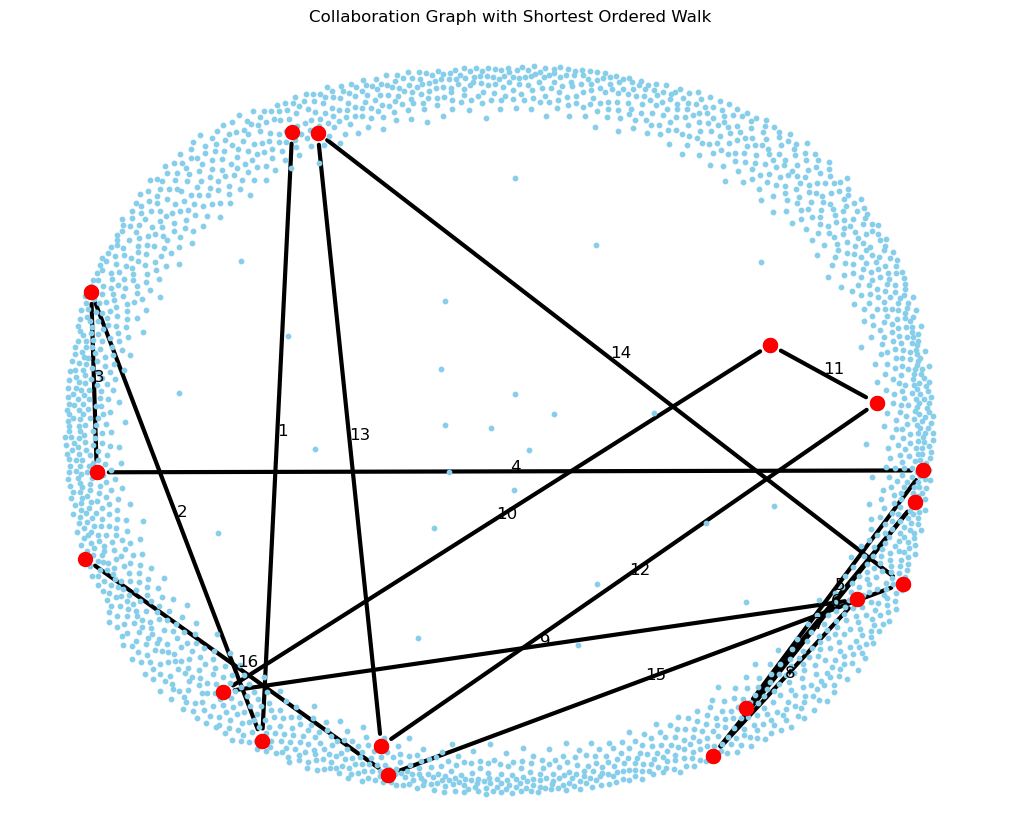

In [104]:
plot_shortest_walk(collaboration_subgraph, shortest_ordered_walk_result)

### Visualization 4 - Visualize the disconnected graph

Here we want to calculate the minimum number of edges to disconnect two specified nodes in a graph.
- This function visualizes the edges between two specified nodes in a graph.
- It takes three parameters: The graph, first node, second node (The nodes between which the edges will be visualized.)

In [160]:
def plot_edges_between_nodes(graph, node_a, node_b):
    edges = list(nx.minimum_edge_cut(graph, node_a, node_b))
    subgraph = graph.edge_subgraph(edges)

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(subgraph)

    nx.draw(subgraph, pos, with_labels=True, font_weight='bold')
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges, edge_color='g', width=2)
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[node_a, node_b], node_color='r', node_size=300)

    plt.title(f'Edges between {node_a} and {node_b}')
    plt.show()

citation_graph, collaboration_graph = read_graphs()
authors_sequence = list(collaboration_graph.nodes())  # Replace this with the appropriate list of authors

In [162]:
# Nodes to visualize edges between
nodeA = '1445484688'
nodeB = '1958887586'

# Calculate the edge connectivity between author A and author B
edge_connectivity = min_edges_to_disconnect(collaboration_graph, nodeA, nodeB, authors_sequence)
print(f"Edge connectivity between {nodeA} and {nodeB}: {edge_connectivity}")

Edge connectivity between 1445484688 and 1958887586: 11


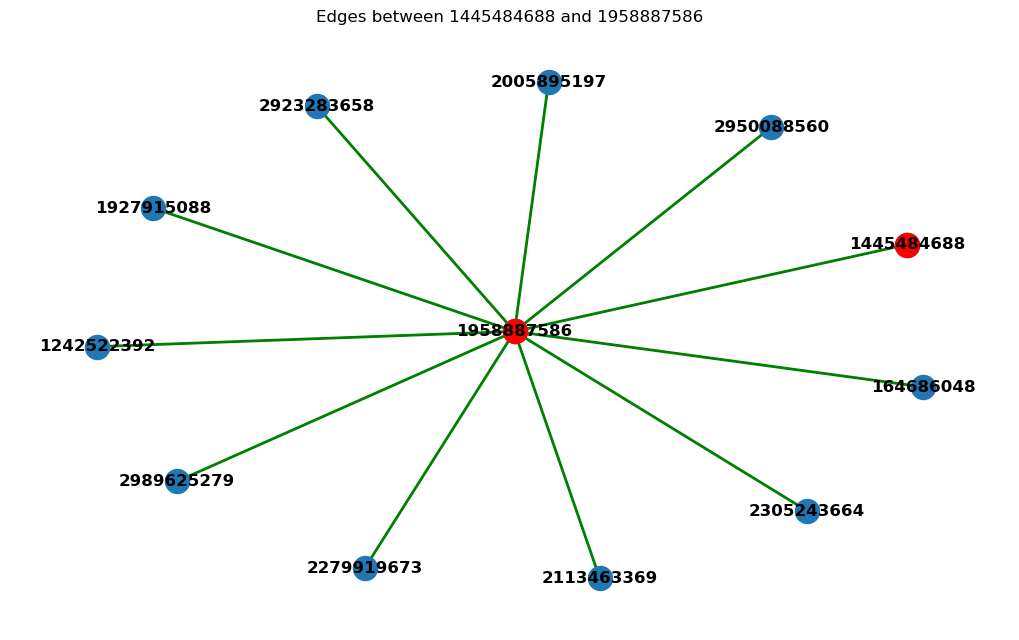

In [163]:
plot_edges_between_nodes(collaboration_graph, nodeA, nodeB)

The edge connectivity of 17 between the nodes 1445484688 and 1958887586 suggests that there are 17 edges whose removal would disconnect these two nodes within the graph. This means that if you were to remove these 17 edges, the graph would be split into two disconnected subgraphs, preventing direct paths between nodes 1445484688 and 1958887586.

In [108]:
def remove_edges_and_plot_subset(subgraph, edges_to_remove, nodes_to_identify):
    
    # Remove the specified edges from the new graph
    subgraph.remove_edges_from(edges_to_remove)

    # Identify the two nodes
    node1, node2 = nodes_to_identify

    # Visualize the modified subgraph after removing edges and identifying nodes
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(subgraph)  # You can use different layouts as well

    # Plot the modified subgraph with removed edges
    nx.draw(subgraph, pos, with_labels=False, node_size=10, node_color='skyblue')
    
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges_to_remove, edge_color='g', width=2)

    # Highlight the identified nodes
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[node1, node2], node_color='r', node_size=300)

    plt.title('Subset of 30 Nodes: Modified Graph after Removing Links and Identifying Nodes')
    plt.show()

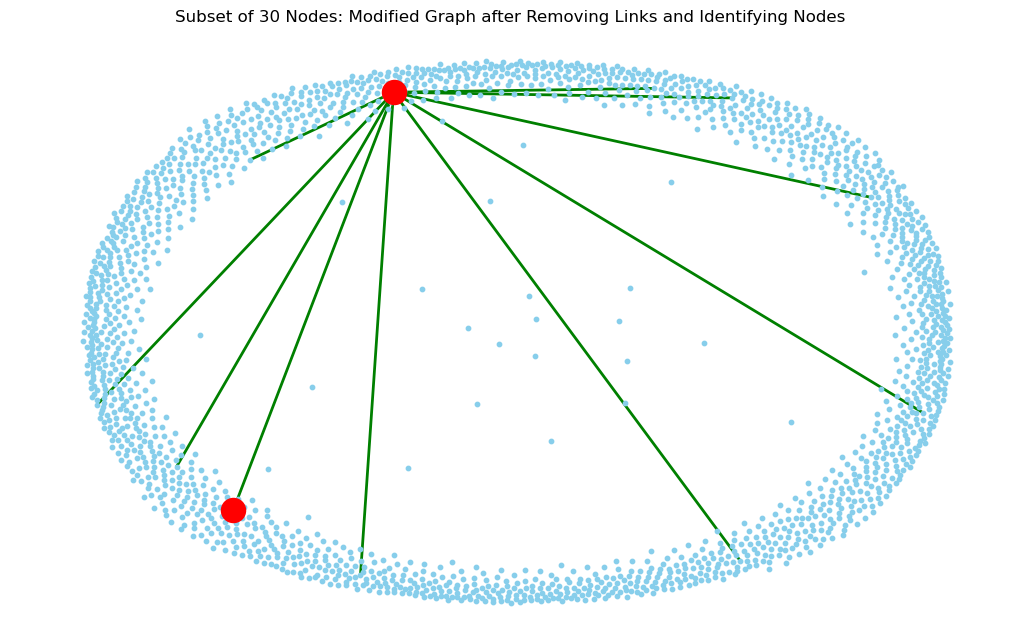

In [109]:
collaboration_subgraph = create_subgraph(collaboration_graph, 2000)

# Nodes to visualize edges between and identify
nodeA = '1445484688'
nodeB = '1958887586'

# Find the edges between the nodes
edges_to_remove = list(nx.minimum_edge_cut(collaboration_graph, nodeA, nodeB))

# Identify the two nodes
nodes_to_identify = [nodeA, nodeB]

# Remove identified edges and plot the modified graph with the subset of nodes
remove_edges_and_plot_subset(collaboration_subgraph, edges_to_remove, nodes_to_identify)

- The green edges should be removed, so these 2 graphs can be disconnected.
- Each red dot, representing our desired nodes. They all are connected to the blue nodes with green edges.
- The green lines are the edges from node A. However, Node B is also connected to the same blue nodes that node A is connected.
- So if we reomove the green lines, they will bee separated.

### Visualization 5 - Visualize the communities

Let's extract communities of just 100 nodes for better illustration:
- Now, let's calculate the Minimum number of edges to remove to form communities
- We also illustrated the communities containing their nodes, among 100 nodes of subgraph
- We declared wheather the paper_1 and paper_2 are comming from the same graph or not.

In [489]:
Paper_1 = '2027658599'
Paper_2 = '2883906439'

result_edges, result_communities, papers_same_community, subgraph = extract_communities(collaboration_graph, Paper_1, Paper_2)

print("Minimum number of edges to remove:", result_edges)
print("-------------------------------------------------")
print("Communities: \n", result_communities)
print("-------------------------------------------------")
print(f"Do Paper_1 and Paper_2 belong to the same community? {papers_same_community}")

Minimum number of edges to remove: 0.8063478996084015
-------------------------------------------------
Communities: 
 [frozenset({'2316043942', '2027658599', '2559180283', '2146468246', '1932590790', '2084034853', '2007415138', '2096217197', '2153440608', '2232649233', '2874782720', '2105531243', '1904226804'}), frozenset({'2883906439', '2298051088', '1445484688', '2915467136', '1927915088', '2596317628', '2617619131', '2305243664', '2229427589'}), frozenset({'2289542319', '1171453863', '563069026', '2575315241', '215131072', '2104401652', '2429370538', '2435751034'}), frozenset({'2119315065', '2163117766', '2114256413', '2006193790', '2139850466', '36403351', '1455141185'}), frozenset({'2126237948', '2189262995', '1991131908', '2163446563', '2165714491', '707865762'}), frozenset({'2150011549', '1208012566', '2120996014', '2175835430'}), frozenset({'2060435928', '1975899429', '310679509', '2977791946'}), frozenset({'2164292938', '2119543935', '2499063207', '2200192130'}), frozenset({'

Here, we just want to plot the original graph, without specifying the communities:

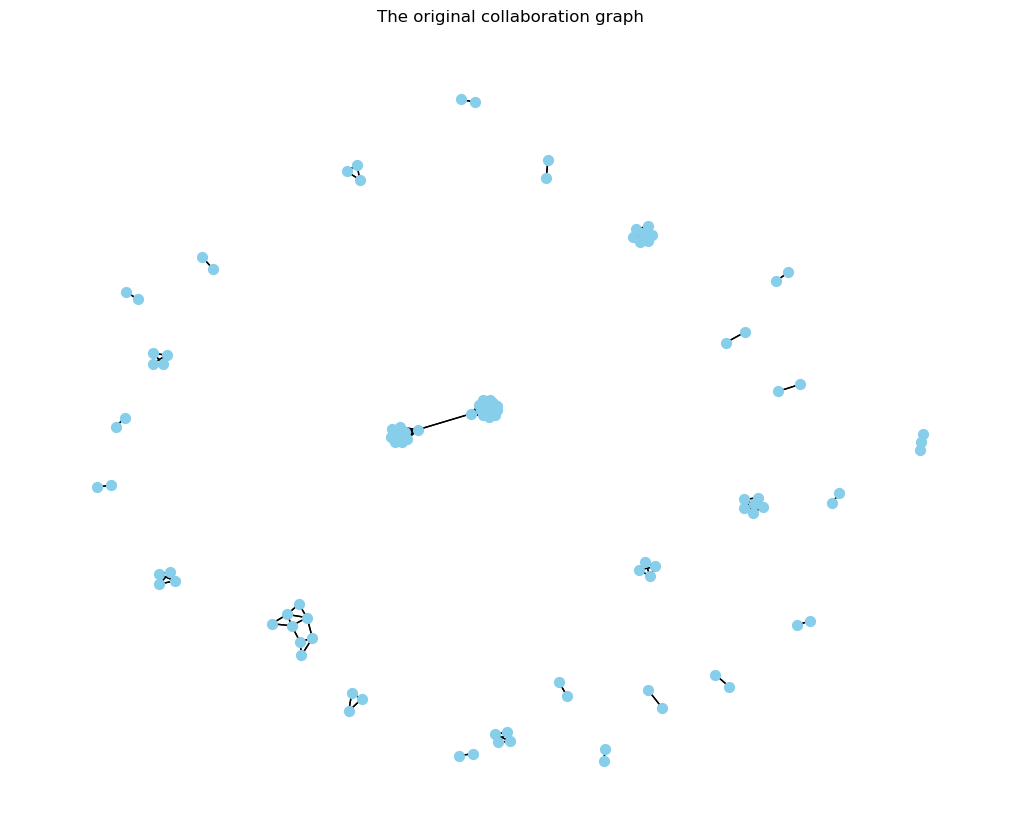

In [491]:
# Create a subgraph from 100 nodes. We also added edges to the subgraph to illustrate in plot.
subgraph = create_subgraph(collaboration_graph, 100, True)

# Plotting the graph with communities highlighted
plt.figure(figsize=(10, 8))
# Set the position of the graph
pos = nx.spring_layout(subgraph)
# draw all nodes of the subgraph with size of 50, without labales
nx.draw(subgraph, pos, with_labels=False, node_size=50, node_color='skyblue')

# Draw edges between nodes
nx.draw_networkx_edges(subgraph, pos)

plt.title('The original collaboration graph')
plt.axis('off')
plt.show()

Here we plot the graph showing the communities in the network

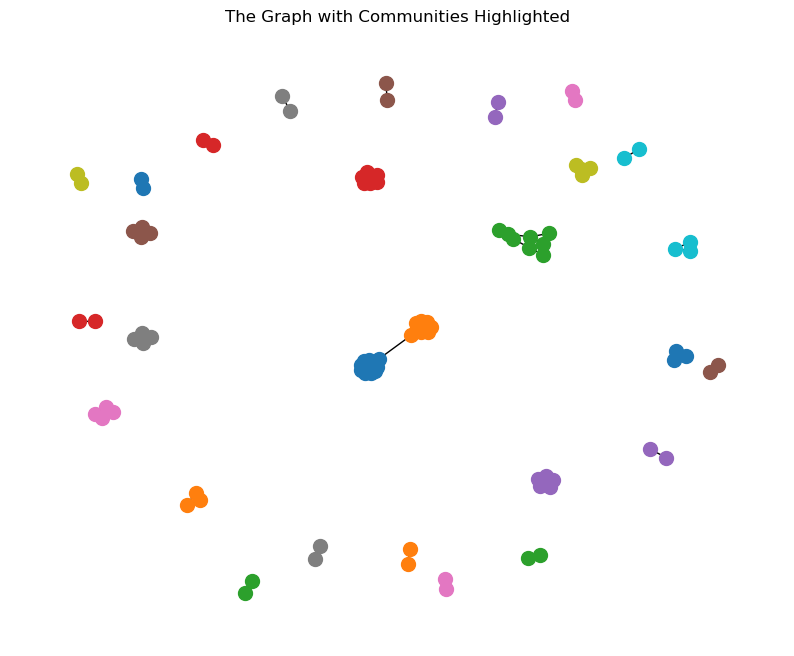

In [492]:
# Plotting the graph with communities highlighted
subgraph = create_subgraph(collaboration_graph, 100, True)

# Plotting the graph with communities highlighted
plt.figure(figsize=(10, 8))
# Set the position of the graph
pos = nx.spring_layout(subgraph)

# Draw edges
nx.draw_networkx_edges(subgraph, pos)

# Highlight communities - aech community has different random color
for i, community in enumerate(result_communities):
    nx.draw_networkx_nodes(subgraph, pos, nodelist=list(community), node_color=f"C{i}", node_size=100)

plt.title('The Graph with Communities Highlighted')
plt.axis('off')
plt.show()

Here we plot the final graph and identify the community/communities of Paper_1 and Paper_2

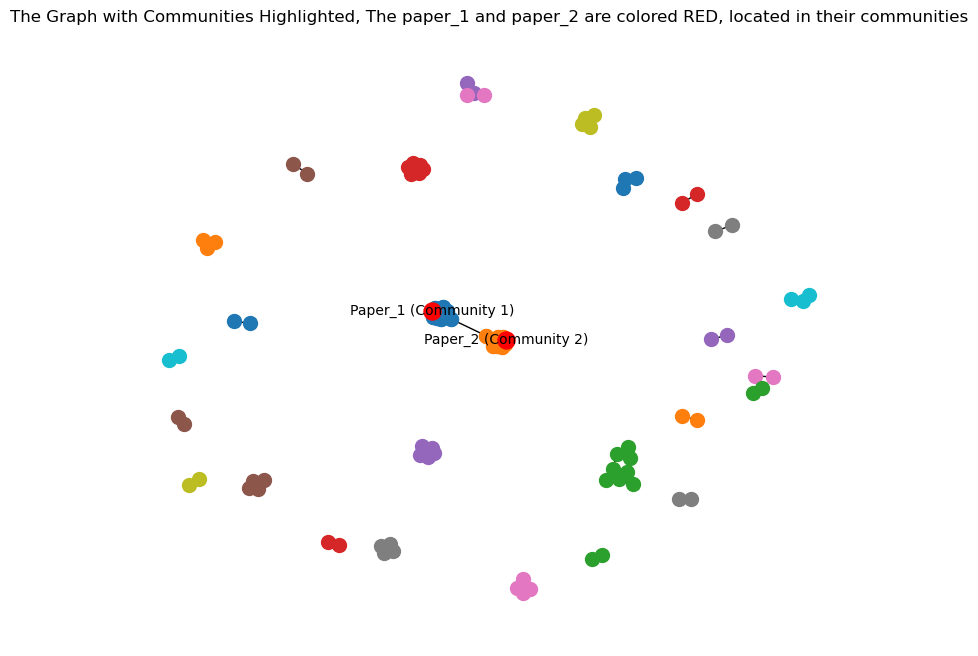

In [493]:
# Plotting the graph with communities highlighted
subgraph = create_subgraph(collaboration_graph, 100, True)

# Plotting the graph with communities highlighted
plt.figure(figsize=(10, 8))
# Set the position of the graph
pos = nx.spring_layout(subgraph)

# Draw edges between nodes of subgraph
nx.draw_networkx_edges(subgraph, pos)

# Highlight communities
for i, community in enumerate(result_communities):
    nx.draw_networkx_nodes(subgraph, pos, nodelist=list(community), node_color=f"C{i}", node_size=100)

# Initialize empty labels dictionary for node labels
node_labels = {}

# Identify the communities of Paper_1 and Paper_2
for i, community in enumerate(result_communities):
    if Paper_1 in community:
        node_labels[Paper_1] = f"Paper_1 (Community {i+1})"
        nx.draw_networkx_nodes(subgraph, pos, nodelist=list(community), node_color=f"C{i}", node_size=100)
    if Paper_2 in community:
        node_labels[Paper_2] = f"Paper_2 (Community {i+1})"
        nx.draw_networkx_nodes(subgraph, pos, nodelist=list(community), node_color=f"C{i}", node_size=100)

# Draw nodes with labels
nx.draw_networkx_nodes(subgraph, pos, node_size=150, node_color='red', nodelist=node_labels.keys())
nx.draw_networkx_labels(subgraph, pos, labels=node_labels, font_size=10, font_color='black')

plt.title('The Graph with Communities Highlighted, The paper_1 and paper_2 are colored RED, located in their communities')
plt.axis('off')
plt.show()

# 3. Bonus - PageRank on MapReduce

Here we're creating our citation graph of 1,000,000 nodes exploiting the same process of the first point by simply changing the nnumber of nodes.

exctract the first 1,000,000 papers with the highest number of citation they received

In [28]:
df = pd.read_csv("./citations_network.csv")

# Convert 'n_citation' column to numeric type if it contains mixed data types
df['n_citation'] = pd.to_numeric(df['n_citation'], errors='coerce')

# Sort the DataFrame by 'n_citation' column in descending order
df_sorted = df.sort_values(by='n_citation', ascending=False)

# Take the top 10,000 rows after sorting and reset the index
df_million = df_sorted.head(1000000).reset_index(drop=True) # changed here the number of rows wanted: 1,000,000

# converting the authors' information from string to list
df_million['authors'] = df_million['authors'].apply(lambda row: ast.literal_eval(row))

/var/folders/d6/sz5pbmks2gs12gkp2yzr1gl00000gn/T/ipykernel_96820/4285923389.py:1: DtypeWarning: Columns (0,2,5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./citations_network.csv")


now we can create our citation graph with 1,000,000 nodes

In [34]:
def citation_dict(row, d={}):
    if pd.notnull(row['references']):
        d[row['id']] = [int(cit) for cit in row['references'].split(';')]
    return d

# creating the graph
G = nx.DiGraph(name = 'Citation Graph')

# adding the nodes and the attributes (the columns of the dataset)
for i, pap in df_million.iterrows():
    node = pap['id']
    attributes = {}
    for el in list(df_million.columns)[1:]:
        attributes[el] = pap[el]
    G.add_node(node, **attributes)
 
# apply the function to each row in the DataFrame to save the citation's relationship in a dictionary
result_dict = {}
for idx, row in df_million.iterrows():
    result_dict = citation_dict(row, result_dict)

for start in result_dict.keys():
    for end in result_dict[start]:
        G.add_edge(start, end)
    
# the graph is created and it's called G
print(f'Number of nodes in the citation Graph considering the first million papers: {len(G.nodes())}')

Number of nodes in the citation Graph considering the first million papers: 2149408


In [47]:
# Map Phase
def map_function(node, score):
    # Check if the node has outgoing links
    if len(G.out_edges(node)) > 0:
        # Emit node ID and its current score divided by the number of outgoing links
        yield node, score / len(G.out_edges(node))
        
        # Emit contributions to linked nodes
        for link in G.neighbors(node):
            yield link, score / len(G.out_edges(node))
    else:
        # If no outgoing links, emit the original score for the node
        yield node, score

# Reduce Phase
def reduce_function(node, contributions):
    # Aggregate scores received by the node
    new_score = damping_factor * sum(contributions) + (1 - damping_factor) / num_nodes
    yield node, new_score

# Initialization
damping_factor = 0.85
num_nodes = len(G.nodes)
initial_score = 1.0 / num_nodes
scores = {node: initial_score for node in G.nodes}

# Iteration
num_iterations = 10000

for iteration in range(num_iterations):
    contributions = {}
    
    # Map Phase
    for node, score in scores.items():
        for emitted_node, contribution in map_function(node, score):
            if emitted_node not in contributions:
                contributions[emitted_node] = []
            contributions[emitted_node].append(contribution)
    
    # Reduce Phase
    new_scores = {}
    for node, new_score in reduce_function(node, contributions.get(node, [])):
        new_scores[node] = new_score
    
    # Update scores for the next iteration
    scores = new_scores

# Final PageRank scores
final_scores = scores
final_scores

{2050655455: 4.652443835698017e-07}

**Comment**

Our output is only one node, the node *2050655455*, with it's importance score of $4.65e-07$; wich is very low.\
This may be due to the fact that the graph is too large and sparse.

In fact, in such a large graph, the majority of the nodes will have a very low PageRank score, since:
- they may have a small number of incoming links;
- the graph may have a lot of disconnected components, and those nodes may not have part of the score computing, due to the lack of connectivity.


In [52]:
# Assuming you have already computed the PageRank scores and stored them in 'final_scores'
# Add PageRank scores as node attributes

subgraph = create_subgraph(G, 100)

nx.set_node_attributes(subgraph, final_scores, 'pagerank')

# Get PageRank scores as a dictionary
pagerank_dict = nx.get_node_attributes(G, 'pagerank')

# Get nodes and their PageRank scores
nodes, scores = zip(*pagerank_dict.items())

# Draw the graph with nodes sized based on PageRank scores
plt.figure(figsize=(10, 8))
# node_size = [score * 20000 for score in scores]  # Adjust the scaling factor as needed
node_size = [score * 100 for score in scores]
pos = nx.spring_layout(G)  # Define layout for the graph
nx.draw(G, pos, node_size=node_size, with_labels=False, node_color='skyblue', alpha=0.7)

# Add a color bar and title
plt.colorbar(nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=scores, cmap=plt.cm.Blues))
plt.title('Graph Visualization with Node Sizes Proportional to PageRank Scores')
plt.show()


# 4. Command Line Question (CLQ)

### 1) Is there any node that acts as an important "connector" between the different parts of the graph?

- Identifying important connector nodes in a graph often involves analyzing nodes with high betweenness centrality. These nodes tend to lie on many shortest paths between other nodes in the graph, acting as connectors between different parts.

- Identifying a node that acts as a crucial connector between different parts of a graph using just grep in Bash is quite challenging due to the complexity of graph structures in GraphML.
  
- However, if we assume that a connector node might be one that has multiple edges connecting it to different parts of the graph, we can attempt to identify such nodes by looking for nodes with higher degrees (nodes with more edges).


The following attempt is to write Python code in Shell environment.

In [ ]:
#!/bin/bash

echo "#-----------------  Q-1  --------------------:"

python3 -c '
import xml.etree.ElementTree as ET

# Parse the GraphML file
tree = ET.parse("Citation_Graph.graphml")
root = tree.getroot()

# Initialize a dictionary to store node degrees
node_degrees = {}

# Find edges and count node degrees
for edge in root.findall(".//{http://graphml.graphdrawing.org/xmlns}edge"):
    source = edge.attrib["source"]
    if source in node_degrees:
        node_degrees[source] += 1
    else:
        node_degrees[source] = 1

# Sort nodes by degree in descending order
sorted_nodes = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True)

# Print nodes with higher degrees
for node, degree in sorted_nodes[:10]:  # Adjust the number to display more or fewer nodes
    print(f"Node ID: {node}, Degree: {degree}")
'

In [ ]:
"""
Node ID: 47957325, Degree: 1287
Node ID: 2076063813, Degree: 564
Node ID: 2148043549, Degree: 480
Node ID: 1660562555, Degree: 434
Node ID: 2024228866, Degree: 430
Node ID: 2115167851, Degree: 413
Node ID: 2040340473, Degree: 400
Node ID: 2150341604, Degree: 375
Node ID: 2158237121, Degree: 366
Node ID: 2108646579, Degree: 356
"""

- We need to count the occurrences of the <edge> or <node> tags within the file to infer the degree of nodes.
- To find nodes with higher degrees (more edges), we can use combination of grep, sed, and awk.

```bash
echo "Nodes with High Degrees: "
# This line returns all nodes that have edges + their number of edges.
grep -o '<edge.*source="[^"]*"' Citation_Graph.graphml | sed 's/.*source="\([^"]*\)"/\1/' | sort | uniq -c | awk '{print $2, $1}'
# This line returns only top 10 selected nodes from sorted degree counts.
grep -o '<edge.*source="[^"]*"' Citation_Graph.graphml | sed 's/.*source="\([^"]*\)"/\1/' | sort | uniq -c | awk '{print $2, $1}' | sort -k2 -nr | head -n 10
```

Step By Step explanation:
- grep -o '<edge.*source="[^"]*"' Citation_Graph.graphml: Extracts lines containing edges and their sources.
- sed 's/.*source="\([^"]*\)"/\1/': Extracts the source nodes from these lines.
- sort | uniq -c: Counts the occurrences of each node (degree calculation).
- awk '{print $2, $1}': Prints the node ID and its degree.
- sort -k2 -nr: Sorts the nodes based on their degree count in reverse numerical order (highest to lowest).
- head -n 10: Selects the top 10 nodes from the sorted list.

In [ ]:
# Here are the nodes with the highest degrees:

"""
#-----------------  Q-1  --------------------:
Nodes with High Degrees: 
47957325 1287
2076063813 564
2148043549 480
1660562555 434
2024228866 430
2115167851 413
2040340473 400
2150341604 375
2158237121 366
2108646579 356
"""

### 2) How does the degree of citation vary among the graph nodes?

- The variation in citation degrees among graph nodes typically represents the connectivity pattern within the graph.

- **Nodes with High Degrees:** Nodes with high citation degrees are often considered influential or central within the network. These nodes tend to be frequently cited, indicating their importance in the field or topic.
  
- **Nodes with Low Degrees:** Nodes with lower citation degrees might represent less influential or less referenced papers/articles. They might be more specific or niche in their content and hence receive fewer citations.

- **Distribution of Degrees:** The distribution of citation degrees across nodes can vary widely. Some graphs might exhibit a power-law distribution where a few nodes have significantly higher degrees than the majority, while others might have a more even distribution.

- **Clusters or Communities:** In some cases, groups of nodes might cite each other extensively, forming clusters or communities within the graph. These clusters might have nodes with higher internal degrees compared to their connections with nodes outside the cluster.

- **Graph Connectivity:** The degree distribution often reflects the connectivity and structure of the graph. In a highly connected graph, there might be fewer nodes with extremely high degrees, while in a sparser graph, the degrees might be more evenly distributed.

```bash
echo "#-----------------  Q-2  --------------------:"

# Extract edges and source nodes, count occurrences of each node
node_degrees=$(grep -o '<edge.*source="[^"]*"' Citation_Graph.graphml | sed 's/.*source="\([^"]*\)"/\1/' | sort | uniq -c | awk '{print $1}')

# Calculate total degrees
total_degrees=$(echo "$node_degrees" | awk '{sum+=$1} END {print sum}')

# Count the number of nodes
total_nodes=$(echo "$node_degrees" | wc -l)

# Calculate average degree
average_degree=$(echo "scale=2; $total_degrees / $total_nodes" | bc)

echo "Total degrees: $total_degrees"
echo "Total nodes: $total_nodes"
echo "Average degree: $average_degree"

echo "Nodes with Low Degrees: "
grep -o '<edge.*source="[^"]*"' Citation_Graph.graphml | sed 's/.*source="\([^"]*\)"/\1/' | sort | uniq -c | awk '{if ($1 <= 5) print $2, $1}' | sort -k2 -n
```

In [ ]:
"""
#-----------------  Q-2  --------------------:
Total degrees: 187811
Total nodes:     8797
Average degree: 21.34
Nodes with Low Degrees: 
2166073443 5
2165205968 5
2164154943 5
2154845780 5
2151554678 5
2150981663 5
2149959815 5
2144654387 5
2144007657 5
2138484437 5
2132755931 5
2124868070 5
2124651399 5
2123060905 5
2122962290 5
2122339645 5
2121255383 5
2120390927 5
2119362555 5
2106006415 5
2102251435 5
2100738443 5
2100677568 5
2097856935 5
2095724872 5
2069123478 5
2047029664 5
2022686119 5
2016589492 5
2008441192 5
1990911977 5
1967661515 5
1596717185 5
2165744313 4
2162598825 4
2155606054 4
2155201844 4
2154774499 4
2147421370 4
2145023731 4
2141157874 4
2128409098 4
2126736494 4
2124591829 4
2120510885 4
2113442785 4
2110899053 4
2110774823 4
2108929776 4
2103496339 4
2102625004 4
2102258543 4
2070571588 4
2045300586 4
2044465660 4
2036265926 4
2006617902 4
1986922155 4
1651117873 4
1595159159 4
1593045043 4
1517555081 4
1482540049 4
2340020088 3
2171074980 3
2165558283 3
2163363194 3
2159482845 3
2153292828 3
2153074919 3
2151693816 3
2150412388 3
2146842127 3
2146058063 3
2143238378 3
2142237411 3
2137015675 3
2132525235 3
2131271579 3
2128728535 3
2128272608 3
2124637492 3
2124351063 3
2123845384 3
2119821739 3
2118898434 3
2118877769 3
2118382442 3
2112665591 3
2111308925 3
2107080958 3
2104925392 3
2103647628 3
2096747776 3
2096710051 3
2045407304 3
2044591029 3
2040903332 3
2033403400 3
2032094184 3
2019363670 3
1991133427 3
1987497363 3
1976677460 3
1971784203 3
1674877186 3
1592870802 3
1578285471 3
2912934387 2
2168405694 2
2168078104 2
2165612380 2
2165467455 2
2157107905 2
2154872931 2
2150297520 2
2146948159 2
2143908786 2
2137983211 2
2133671888 2
2133475491 2
2130509920 2
2128880918 2
2128572087 2
2127396309 2
2125910575 2
2125092464 2
2114104545 2
2112192177 2
2111706174 2
2110035718 2
2106403318 2
2098162425 2
2097341408 2
2095659828 2
2057361103 2
2054658115 2
2043769961 2
2031614119 2
2029050771 2
2026161499 2
2022950330 2
2020804487 2
1993885071 2
1976109068 2
1964962870 2
1644882639 2
1577668191 2
1547450212 2
2341865734 1
2169528473 1
2169245194 1
2166056089 1
2165363188 1
2163097950 1
2159498975 1
2156718197 1
2156434383 1
2151408086 1
2149992227 1
2146292423 1
2141616651 1
2140886907 1
2131222241 1
2130736456 1
2123184444 1
2122732537 1
2120865735 1
2119632499 1
2103953153 1
2103120971 1
2102619694 1
2102234847 1
2097897435 1
2094204865 1
2093274439 1
2081580037 1
2079325629 1
2031604650 1
1998017916 1
1992176519 1
1990100773 1
1982300822 1
1975442866 1
1973501242 1
"""

### 3. What is the average length of the shortest path among nodes?

   - Calculating the average length of the shortest path among nodes using awk, sed, and grep for a graph is quite complex due to the nature of graph traversal algorithms and their intricacies. These tools are not suitable for efficiently implementing graph algorithms like BFS. So we used Python syntax in Shell code.

In [ ]:
#!/bin/bash

echo "#-----------------  Q-3  --------------------:"

python3 -c '
import networkx as nx

# Define your graph or load it from a file
# Example: Load graph from a GraphML file
G = nx.read_graphml("Citation_Graph.graphml")

# Calculate the sum of shortest path lengths between all pairs of nodes
total_length = sum(len(path) - 1 for source in G for target, path in nx.bfs_edges(G, source=source))

# Calculate the total number of paths (excluding self-paths)
total_paths = sum(1 for source in G for _ in nx.bfs_edges(G, source=source))

# Calculate the average shortest path length
average_length = total_length / total_paths if total_paths > 0 else 0

print(f"Average shortest path length: {average_length}")

In [ ]:
"""
#-----------------  Q-3  --------------------:
Average shortest path length: 8.930833572239766
"""

### Screen Shots:

![](./CLQ-Q1-Q2-Screenshot.png)
![](./CLQ-Q2-Q3-Screenshot.png)

# 5. Algorithmic Questions (AQ)

### Part A

##### 1. Implement an algorithm to solve the described mentioned problem.

Lets create our function:

In [1]:
from collections import Counter

def max_score(athlete_skills, skills):
    # We store the athletes for each skill
    athletes_by_skill = {skill: set() for skill in set(skills)}

    # We add values to the set with unique athlete IDs and scores sorted by skill value
    for athlete_id, athlete_skills in athlete_skills.items():
        for skill in skills:
            if skill in athlete_skills:
                athletes_by_skill[skill].add((athlete_id, athlete_skills[skill]))

    # We count the occurrences of each skill
    skill_counts = Counter(skills)

    # We create a dictionary
    Skills_repeated = {skill: count for skill, count in skill_counts.items() if count > 0}

    # We extract the top athletes for each skill based on the occurrences in the skill list
    top_athletes_by_skill = {skill: sorted(athletes, key=lambda x: x[1], reverse=True)[:Skills_repeated.get(skill, 1)] for skill, athletes in athletes_by_skill.items()}

    # And lastly we calculate the total score for top athletes
    total_score_all_athletes = sum(score for skill, athletes in top_athletes_by_skill.items() for _, score in athletes)

    # Now we look for repeated athletes
    # extracting the athlete who is repeated in top_athletes_by_skill
    repeated_athletes = set()
    repeated_in_top_athletes = set()
    for skill, top_athletes in top_athletes_by_skill.items():
        for athlete_id, _ in top_athletes:
            if athlete_id in repeated_athletes:
                repeated_in_top_athletes.add(athlete_id) #We add them to this list
            else:
                repeated_athletes.add(athlete_id)


    # We create a copy of the athletes_by_skill dictionary to use it
    athletes_by_skill_copy = athletes_by_skill.copy()

    # We do a loop if there is an athlete repeated
    if repeated_in_top_athletes != set():

        # We create a list to store total scores after each removal
        total_scores_after_removal = []

        # We loop over each ID in repeated_in_top_athletes
        for athlete_id in repeated_in_top_athletes:
            # We create a new copy of athletes_by_skill from the previous copy
            athletes_by_skill_new = athletes_by_skill_copy.copy()

            # We select the skills corresponding to the current athlete_id
            skills_for_current_athlete = [skill for skill, athletes in athletes_by_skill_new.items() if any(athlete[0] == athlete_id for athlete in athletes)]

            # We eliminate the athlete with the current ID from each skill
            for skill in skills_for_current_athlete:
                # We take the again the copy and eliminate the athlete in the skill
                athletes_by_skill_new = athletes_by_skill_copy.copy()
                athletes_by_skill_new[skill] = [athlete for athlete in athletes_by_skill_new[skill] if athlete[0] != athlete_id]

                # We recalculate the top athletes for each skill
                top_athletes_by_skill = {skill: sorted(athletes, key=lambda x: x[1], reverse=True)[:Skills_repeated.get(skill, 1)] for skill, athletes in athletes_by_skill_new.items()}

                # We recalculate the total score for all athletes
                total_score_all_athletes = sum(score for skill, athletes in top_athletes_by_skill.items() for _, score in athletes)

                # We append the total score to the list
                total_scores_after_removal.append(total_score_all_athletes)

        # We return the maxmimum scores after each removal
        return max(total_scores_after_removal)

    else:
        return total_score_all_athletes
        

Lets try it with our inputs

In [2]:

# We select the N, M, S values and skills
N, M, S = map(int, input().split())
skills = input().split()

athlete_skills = {}

# We enter all the athletes skills and values
for _ in range(N):
    athlete_id = int(input())
    athlete_data = {}
    for _ in range(S):
        skill, score = input().split()
        athlete_data[skill] = int(score)
    athlete_skills[athlete_id] = athlete_data

# We call the function
result = max_score(athlete_skills, skills)

# And print the result
print(result)

 14 10 1
 SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
 1
 BSK 98
 2
 ATH 14
 3
 HCK 82
 4
 HCK 9
 5
 FTB 90
 6
 ATH 52
 7
 HCK 95
 8
 TEN 85
 9
 RGB 46
 10
 SWM 16
 11
 VOL 32
 12
 SOC 41
 13
 SWM 59
 14
 SWM 34


370


Great! Our algorithm worked for our first input.


Lets try the second input:

In [3]:
 
# We select the N, M, S values and skills
N, M, S = map(int, input().split())
skills = input().split()

athlete_skills = {}

# We enter all the athletes skills and values
for _ in range(N):
    athlete_id = int(input())
    athlete_data = {}
    for _ in range(S):
        skill, score = input().split()
        athlete_data[skill] = int(score)
    athlete_skills[athlete_id] = athlete_data

# We call the function
result = max_score(athlete_skills, skills)

# And print the result
print(result)


 14 10 2
 SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
 1
 BSK 98
 HCK 12
 2
 ATH 14
 VOL 1
 3
 HCK 82
 ATH 30
 4
 HCK 9
 SWM 27
 5
 FTB 90
 HCK 50
 6
 ATH 52
 RGB 80
 7
 HCK 95
 SWM 11
 8
 TEN 85
 RGB 7
 9
 RGB 46
 SWM 30
 10
 SWM 16
 BSK 12
 11
 VOL 32
 HCK 40
 12
 SOC 41
 FTB 12
 13
 SWM 59
 TEN 82
 14
 SWM 34
 VOL 20


399


Again! The algorithm also worked for the second input. We have solved this first task.


##### 2. What is the time complexity (the Big O notation) of your solution? Please provide a detailed explanation of how you calculated the time complexity.



Lets do it by parts:

- The first part of the code, the one that initializes a dictionary athletes_by_skill. 
In this part the algorithm search for each skill, all the skills for each athlete. Therefore it has a time complexity O(NSM).

- Then we count the occurences of each skill, that's O(M)

- Followed by the extraction of the top athletes for each skill based on their occurrences, and calculates the total score for these top athletes.
This one is the most complexe for this first part. Since, here for each athlete in each skill, it gets the n best athletes (n corresponding to the number of time that skill appears in the skills list). For this it has to sort the athletes. So time complexity is O(SMN*log(N)).

- The next step is to identifie repeated athletes in the top athletes for different skills.
This one is simple also, just compare to see if an athlete appears more than once. the time complexity is O(MN)

- And for the ending, if there are repeated athletes, we do the same code as previously but by eliminating first one of the skills of each repeated athlete. So It's O(RSMN*log(N)) with R the numbers of repeated athletes.


Then the final time complexity is O(RSMN * log(N)), since is the most important one. But taking in count this time complexity is only appearing whhen we have repeated athletes, we may approximate to O(MNS * log(N)).


##### 3. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. If the two differ, which one is right? (why?)


At first Chatgpt answered that the time complexity is O(M * N * log(N)), where M is the number of skills, and N is the number of athletes. Sorting the athletes for each skill is the main contributor to the overall time complexity. It is clear the it forgot S, so I remind it. he changed it answer: 'the dominant factor is still the sorting of athletes for each skill. Therefore, the overall time complexity is approximately O(S * M * N * log(N)).'

This does not differ from what we just said previously doing the approximation, but it is not talking in account the number of athletes repeated.

##### 4. If you algorithm has exponential time complexity, can you provide a polynomial_time version?

A exponential time complexity is represented as O(n^k), where n is the size of the input and k is a constant exponent. In this case, S, M, and N are not considered constants, they represent the sizes of different aspects of the input. This means our aglgorithm has already a polynomial time complexity.

##### 5. If S = 1, how does the time complexity of an optimal algorithm to solve this problem change?

If S = 1, the time complexity is much easier. Lets see this code we made in a first place to solve the first input that has S = 1.

In [24]:
athlete_skills = {
    1: {'BSK': 98},
    2: {'ATH': 14},
    3: {'HCK': 82},
    4: {'HCK': 9},
    5: {'FTB': 90},
    6: {'ATH': 52},
    7: {'HCK': 95},
    8: {'TEN': 85},
    9: {'RGB': 46},
    10: {'SWM': 16},
    11: {'VOL': 32},
    12: {'SOC': 41},
    13: {'SWM': 59},
    14: {'SWM': 34},
}

skills = ['SWM', 'VOL', 'ATH', 'VOL', 'VOL', 'BSK', 'HCK', 'BSK', 'SWM', 'BSK']

# We initialize a list to track the cumulative scores for each skill
skill_scores = [{'skill': skill, 'max_score': 0, 'max_athlete_id': 0} for skill in skills]

# We iterate through athlete_skills to update the skill_scores
selected_athletes = set()
for skill_info in skill_scores:
    skill = skill_info['skill']
    for athlete_id, athlete_skills_info in athlete_skills.items():
        if skill in athlete_skills_info and athlete_id not in selected_athletes:
            # We update max score and corresponding athlete ID if the current athlete has a higher score and that hasn't already been selected
            if athlete_skills_info[skill] > skill_info['max_score']:
                skill_info['max_score'] = athlete_skills_info[skill]
                skill_info['max_athlete_id'] = athlete_id
                selected_athletes.add(athlete_id)

# We sum all the max scores from skill_scores
total_max_score = sum(skill_info['max_score'] for skill_info in skill_scores)

print("Max Score:", total_max_score)


Max Score: 370


Here we only have one loop that runs through all the skills and then select the best athlete for each skill, therefore the time complexity of the given code is polynomial and can be expressed as O(M * N). This is much less complex that our previuos one O(NMS*log(N)).

### Part B

##### 1. Prove or disprove that the problem is NP-complete

To ascertain whether the team selection problem is NP-complete, we must establish both its NP membership and NP-hardness.

In terms of NP membership, the team selection problem falls within NP, as we can efficiently verify its criteria: skill coverage and low effort. Regarding skill coverage, the process involves comparing team members' skills to the required set, scaling polynomially with the team size and skill set. On the other hand, for low effort verification, determining the minimum spanning tree (MST) cost on the subgraph induced by selected team members can be done efficiently with algorithms like Prim's or Kruskal's, running in polynomial time.

Now, to prove NP-hardness, we perform a reduction from the well-known NP-complete vertex cover problem to the team selection problem. The vertex cover problem, which seeks to select the minimum number of vertices in a graph ensuring each edge is incident to at least one selected vertex, serves as our target. This way, through a reduction process, we construct a team selection problem instance mirroring the vertex cover problem instance.

This construction links the vertex cover problem's solution to the team selection problem, where a solution with minimum effort aligns with the minimum spanning tree weight in the team compatibility graph.

Consequently, this reduction establishes that the team selection problem is NP-hard by connecting it to the NP-complete vertex cover problem.
Therefore, we can clonclude that the team selection problem seems NP-complete.

#### 2. Write a heuristic in order to approximate the best solution for this problem.

Since the team selection problem is NP-complete, finding the optimal solution requires an exhaustive search, which is computationally intractable for large problem instances. That why heuristic algorithms are a class of algorithms that can provide an approximate solution to a problem that are hard to solve exactly. These algorithms employ search strategies and problem-specific knowledge to find good solutions quickly. 

Lets go with a simple one:

First we are going to get the weights between the athletes, to see how the graph can be represented.

To get the weight of effort we will compare the difference of scores between two athletes using the MST. The higher the difference, the more difficulty they are going to find to work together, their skills are not matching. This is simple but effective.

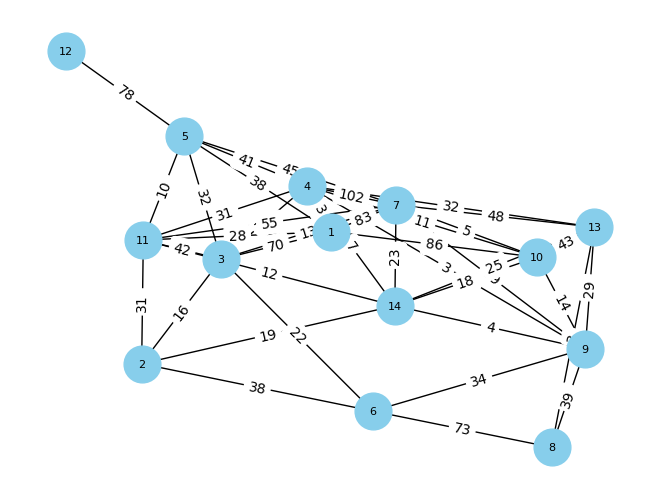

In [119]:
import networkx as nx
import matplotlib.pyplot as plt


athlete_skills = {
    1: {'BSK': 98, 'HCK': 12},
    2: {'ATH': 14, 'VOL': 1},
    3: {'HCK': 82, 'ATH': 30},
    4: {'HCK': 9, 'SWM': 27},
    5: {'FTB': 90, 'HCK': 50},
    6: {'ATH': 52, 'RGB': 80},
    7: {'HCK': 95, 'SWM': 11},
    8: {'TEN': 85, 'RGB': 7},
    9: {'RGB': 46, 'SWM': 30},
    10: {'SWM': 16, 'BSK': 12},
    11: {'VOL': 32, 'HCK': 40},
    12: {'SOC': 41, 'FTB': 12},
    13: {'SWM': 59, 'TEN': 82},
    14: {'SWM': 34, 'VOL': 20},
}

skills = ['SWM', 'VOL', 'ATH', 'VOL', 'VOL', 'BSK', 'HCK', 'BSK', 'SWM', 'BSK']

# We calculate the effort weights and create a graph
G = nx.Graph()
for athlete_id, athlete_skill in athlete_skills.items():
    G.add_node(athlete_id, skills=athlete_skill)

for i in range(1, len(athlete_skills) + 1):
    for j in range(i + 1, len(athlete_skills) + 1):
        athlete_i_skills = set(athlete_skills[i].keys())
        athlete_j_skills = set(athlete_skills[j].keys())
        common_skills = athlete_i_skills.intersection(athlete_j_skills)

        # we calculate the effort weight based on common skills
        effort_weight = sum(abs(athlete_skills[i][skill] - athlete_skills[j][skill]) for skill in common_skills)

        # we add an edge to the graph with the calculated effort weight
        if effort_weight > 0:
            G.add_edge(i, j, weight=effort_weight)

# We plot
pos = nx.spring_layout(G)  
edge_labels = {(i, j): G[i][j]['weight'] for i, j in G.edges()}
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()


Here we can see all the combinations with all the values. We can see the athlete 12 appart since his skills are only shared with the athlete 5 in 'SOC'.

Now, lets choose a randome set of players and calculate the weight of the team. Once we have the effort of the team, we are going to repeat this process a number of T times. At the en we will compare the results and get the team with the lower effort to work together.

Best Team: {'VOL': [14, 2, 11], 'HCK': [1], 'SWM': [9, 4], 'BSK': [10], 'ATH': [6]}
Effort of the Best Team : 34


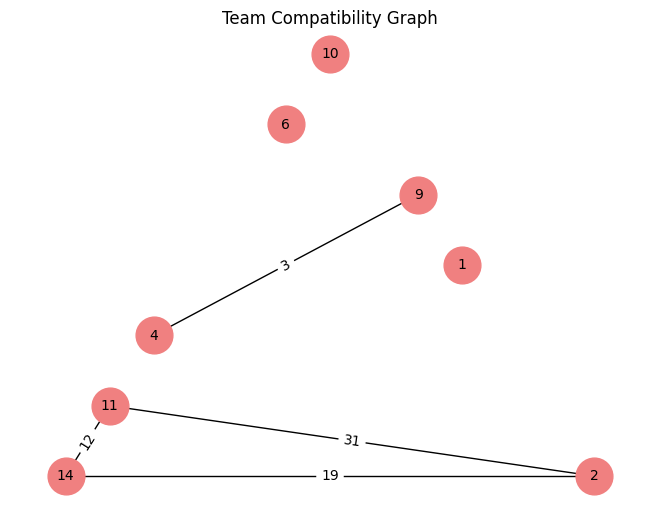

In [128]:
import random
import networkx as nx
import matplotlib.pyplot as plt

# We count the number of times the skills appear
skills_count = {skill: skills.count(skill) for skill in set(skills)}

# We create the function to calculate effort for a given team
def effort(G_team):
    mst_edges = nx.minimum_spanning_tree(G_team, weight='weight').edges(data=True)
    total_effort = sum(data['weight'] for _, _, data in mst_edges)
    return total_effort

# We create the function to generate a random team
def random_team_athletes(athlete_skills, skills_count):
    random_team = {}
    selected_athletes = set()

    for skill, count in skills_count.items():
        available_athletes = [athlete for athlete, athlete_skills in athlete_skills.items() if skill in athlete_skills and athlete not in selected_athletes]
        i = 0
        while available_athletes and i < count:
            selected_athlete = random.choice(available_athletes)
            selected_athletes.add(selected_athlete)
            random_team[skill] = random_team.get(skill, []) + [selected_athlete]
            available_athletes.remove(selected_athlete)  # Remove selected athlete from the pool
            i += 1

    return random_team

# How many times we want to repeat the process?
T_process = 100

# Lets initialize variables for the best team and its effort
best_team = None
best_effort = float('inf')

# We generate and evaluate multiple random teams
for _ in range(T_process):
    # we generate a random team
    current_team = random_team_athletes(athlete_skills, skills_count)

    # We again create Graph
    G_team = nx.Graph()
    for skill, athletes in current_team.items():
        for athlete_id in athletes:
            G_team.add_node(athlete_id, skills=athlete_skills[athlete_id])

    for skill, athletes in current_team.items():
        for i in range(len(athletes)):
            for j in range(i + 1, len(athletes)):
                athlete_i = athletes[i]
                athlete_j = athletes[j]
                common_skills = set(athlete_skills[athlete_i].keys()).intersection(set(athlete_skills[athlete_j].keys()))

                # We calculate the effort weight
                effort_weight = sum(abs(athlete_skills[athlete_i][s] - athlete_skills[athlete_j][s]) for s in common_skills)

                # WE add an edge to the team compatibility graph
                G_team.add_edge(athlete_i, athlete_j, weight=effort_weight)

    # We calculate the total effort of the current team
    current_effort = effort(G_team)

    # We compare and update
    if current_effort < best_effort:
        best_team = current_team
        best_effort = current_effort
        B_team = G_team

# We print 
print("Best Team:", best_team)
print("Effort of the Best Team :", best_effort)


# We plot
pos_team = nx.planar_layout(B_team)
edge_labels_team = {(i, j): B_team[i][j]['weight'] for i, j in B_team.edges()}
nx.draw(B_team, pos_team, with_labels=True, node_size=700, node_color='lightcoral', font_size=10)
nx.draw_networkx_edge_labels(B_team, pos_team, edge_labels=edge_labels_team)
plt.title("Team Compatibility Graph")
plt.show()



Here we can see that the best team has an effort to work together of 34 ((19 + 12 + 31)/2 + 3 = 62/2 + 3 = 31 + 3 = 34). 

The result is not bad, but we have to take in account that this result is due to the fact that our code is only taking in count the athletes that share same discipline of the sport they were selected to participate. Then, what is happening here, is that the other athlete with a BSK skill is selected in the SWM team. Therefore, it cannot be selected to the BSK team. And this leads to not have that big difference between athlete 1 and 10, that will get the record waty higher.

#### 3. What is the time complexity of your solution?

For this algorithm, the time complexity is not much more complexe than previously in part A. Lets take a dive into this algorithm complexity.

First, the team random generator is pretty simple, the algorithm run throught the skills, and each skill of each athlete, so we have an O(NMS) order. But it does it T times, so we get an O(TNMS) complexity time.

In a second part, for the effort calculation, we run again throught M, and N, and we run two times throught S, one for each athlete compare. This give us a complexity of O(NMS^2). Again, we don't have to forget that is inside the T loop. So a final time complexity of O(TNMS^2).

Lastly the Minimum Spanning Tree Calculation complexity follows O(E * log(V)). With E (number of edges), that can be told as an order of O(MS^2), and V (number of vertices), is on the order of O(MS). But again inside the loop, that give us then: Time Complexity: O(TMS^2 * log(TMS)).

So the final complexity is in the order of this last one: O(TMS^2 * log(TMS)).